## Compuational Machine Learning Assignment 2
### Classification of Images of Road Traffic Signs


* Ashwin Sreejit -

* Madhurima Khirbat - s3994607


#### Introduction
* In this assesment, we aim to classifiy the trafiic signs on the basis of the Shape and Type


##### Loading necessary packages and reading the data from the folders

In [241]:
import splitfolders
import shutil
import os
from PIL import Image
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model


global augmented
augmented = False

#### Build Train/Test/Validation datasets from the given dataset

In [247]:
# Creating a building directory dictionary to store the image data 
def build_directory_dict(root_dir):
    directory_dict = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if dirpath != root_dir:
            parent_dir = os.path.basename(dirpath)
            if parent_dir not in directory_dict:
                directory_dict[parent_dir] = []
            for dirname in dirnames:
                directory_dict[parent_dir].append(dirname)

    # check if values for any key is empty then remove that key value pair from dict
    dict_copy = directory_dict.copy()
    print(dict_copy)
    for key, value in dict_copy.items():
        if not value:
            del directory_dict[key]
    return directory_dict

In [6]:
def copy_data_to_dest(source, dest, class_labels, split_ratios):

    for shape, types in class_labels.items():
        src = source + '/' + shape
        temp_dir = source + '/temp/' + shape

        if (os.path.exists(temp_dir)):
            shutil.rmtree(temp_dir) 

        splitfolders.ratio(src, output=temp_dir, ratio=split_ratios, seed=1337)
      
        for type_val in types:
            shutil.move(temp_dir + '/train/' + type_val, dest + '/train/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/test/'  + type_val, dest + '/test/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/val/'   + type_val, dest + '/val/' + shape + '/' + type_val)
        
    shutil.rmtree(r'./Dataset/trafficsigns_dataset/temp')

In [7]:
# use split folders to split the dataset into train, test and validation datasets
def create_train_test_val(split_ratios, src, dest):
    if (os.path.exists(dest)):
        shutil.rmtree(r'./Dataset/train_test_val') 
    splitfolders.ratio(src, output=dest, seed=1337, ratio=split_ratios)
    class_labels = build_directory_dict(src)
    copy_data_to_dest(src, dest, class_labels, split_ratios)

In [8]:
create_train_test_val(split_ratios=(0.6, 0.2, 0.2), src='Dataset/trafficsigns_dataset', dest='Dataset/train_test_val')  

Copying files: 0 files [00:00, ? files/s]


{'round': ['speed', 'bicycle', 'traveldirection', 'roundabout', 'trafficdirective', 'noentry', 'noparking', 'limitedtraffic'], 'speed': [], 'bicycle': [], 'traveldirection': [], 'roundabout': [], 'trafficdirective': [], 'noentry': [], 'noparking': [], 'limitedtraffic': [], 'hex': ['stop'], 'stop': [], 'square': ['continue', 'crossing', 'laneend', 'parking'], 'continue': [], 'crossing': [], 'laneend': [], 'parking': [], 'diamond': ['rightofway'], 'rightofway': [], 'triangle': ['warning', 'giveway'], 'warning': [], 'giveway': []}


Copying files: 1760 files [00:00, 30228.72 files/s]
Copying files: 43 files [00:00, 20101.99 files/s]
Copying files: 688 files [00:00, 20753.58 files/s]
Copying files: 282 files [00:00, 21869.97 files/s]
Copying files: 926 files [00:00, 24411.70 files/s]


Fetch the images from the folder and build a dataframe

In [9]:
def build_df_from_image_list(image_list):
    df = pd.DataFrame(image_list, columns = ['Path', 'Shape', 'Type'])
    return df

In [10]:
def fetch_images(root_path):
    image_list = []
    for filepath in glob.glob(root_path, recursive=True): #assuming gif
      shape = filepath.split('/')[3]
      types = filepath.split('/')[4]
      image_list.append((filepath, shape, types))
    
    df = build_df_from_image_list(image_list)
    return df

In [11]:
train = fetch_images('Dataset/train_test_val/train/*/*/*.png')
test = fetch_images('Dataset/train_test_val/test/*/*/*.png')
val = fetch_images('Dataset/train_test_val/val/*/*/*.png')

In [12]:
val.head()

Path  Shape   Type
0  Dataset/train_test_val/val/round/speed/01502_0...  round  speed
1  Dataset/train_test_val/val/round/speed/01774_0...  round  speed
2  Dataset/train_test_val/val/round/speed/01849_0...  round  speed
3  Dataset/train_test_val/val/round/speed/01519_0...  round  speed
4  Dataset/train_test_val/val/round/speed/00935_0...  round  speed

In [13]:
def print_data_info(train, test, val, key='Shape'):
    print("########################## Shape ##########################")
    print(f" Train: {train.shape}, Test: {test.shape}, Val: {val.shape}\n",)
    print("########################## Unique ##########################")
    print("Total Classes: ", len(train[key].unique()))
    print(f" Train: {train[key].unique()}, \nTest: {test[key].unique()}, \nVal: {val[key].unique()}\n")
    print("########################## Count ##########################")
    print(f" Train: {train[key].value_counts()}, Test: {test[key].value_counts()}, Val: {val[key].value_counts()}\n")


In [14]:
print_data_info(train, test, val, key='Shape')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  5
 Train: ['round' 'hex' 'square' 'diamond' 'triangle'], 
Test: ['round' 'hex' 'square' 'diamond' 'triangle'], 
Val: ['round' 'hex' 'square' 'diamond' 'triangle']

########################## Count ##########################
 Train: Shape
round       1054
triangle     555
square       411
diamond      169
hex           25
Name: count, dtype: int64, Test: Shape
round       356
triangle    186
square      141
diamond      57
hex          10
Name: count, dtype: int64, Val: Shape
round       350
triangle    185
square      136
diamond      56
hex           8
Name: count, dtype: int64



In [15]:
print_data_info(train, test, val, key='Type')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  16
 Train: ['speed' 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective'
 'noentry' 'noparking' 'limitedtraffic' 'stop' 'continue' 'crossing'
 'laneend' 'parking' 'rightofway' 'warning' 'giveway'], 
Test: ['speed' 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective'
 'noentry' 'noparking' 'limitedtraffic' 'stop' 'continue' 'crossing'
 'laneend' 'parking' 'rightofway' 'warning' 'giveway'], 
Val: ['speed' 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective'
 'noentry' 'noparking' 'limitedtraffic' 'stop' 'continue' 'crossing'
 'laneend' 'parking' 'rightofway' 'warning' 'giveway']

########################## Count ##########################
 Train: Type
warning             417
noentry             225
speed               189
bicycle             171
rightofway          169
parking       

Visualise Data

In [16]:
def visualise_data(df):
    # plot distribution of each class
    fig, axs = plt.subplots(1, 2, figsize=(20,6))

    # Plot distribution of each class within shape
    sns.countplot(data=df, x='Shape', ax=axs[0])
    axs[0].set_title('Distribution of Shapes')

    # Plot distribution of each class within type
    sns.countplot(data=df, y='Type', ax=axs[1])
    axs[1].set_title('Distribution of Types')

    plt.tight_layout()
    plt.show()

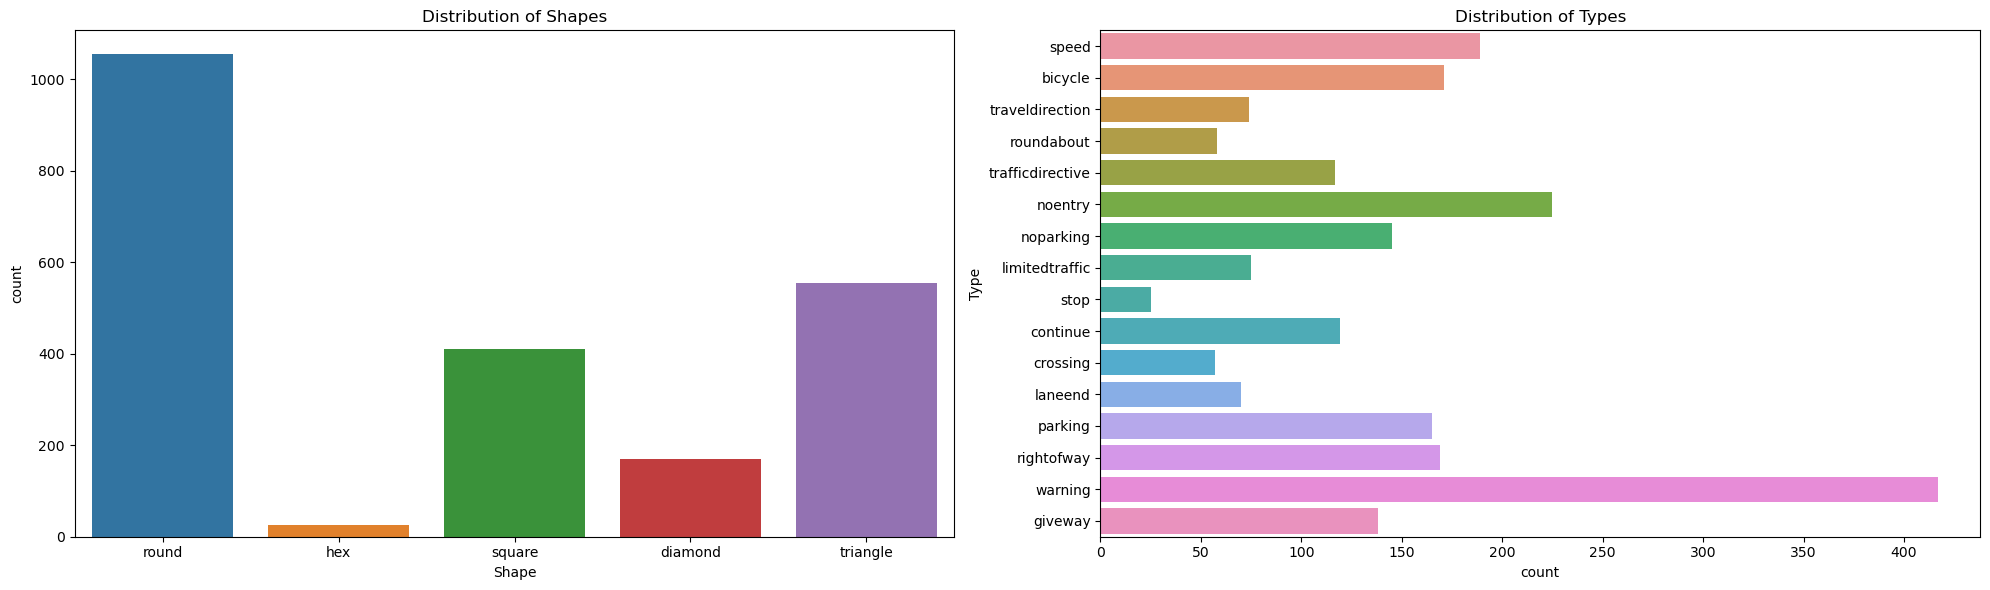

In [17]:
visualise_data(train)

In [18]:
# Iterate through each image path in the DataFrame
def check_image_dimensions(df):
    for index, row in df.iterrows():
        image_path = row['Path']
        flag = False

        # Open the image using PIL
        with Image.open(image_path) as img:
            width, height = img.size
            # Check if dimensions are not 28x28
            if width != 28 or height != 28:
                flag = True
                print(f"Image at path {image_path} has dimensions {width}x{height}")

    if not flag:
        return "All images have dimensions 28x28"

In [19]:
print(f"Train: {check_image_dimensions(train)}\n Test: {check_image_dimensions(test)}\n Val: {check_image_dimensions(val)}")    

Train: All images have dimensions 28x28
 Test: All images have dimensions 28x28
 Val: All images have dimensions 28x28


Display images

In [55]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [150, 150])  
    return image

In [213]:
def display_images(data, column, num_images):
    categories = data[column].unique()  # Get unique categories in the specified column
    
    for cat in categories:
        # Filter data for the current category
        category_data = data[data[column] == cat]
        
        # Sample a subset of images for display (up to num_images)
        sample_paths = category_data['Path'].sample(min(num_images, len(category_data))).values
        
        # Display images for the current category
        plt.figure(figsize=(15, 2))
        plt.suptitle(f'{column}: {cat}', fontsize=10)
        for i, image_path in enumerate(sample_paths):
            image = load_image(image_path).numpy().astype("uint8")
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            # plt.title(cat)
            plt.axis("off")
        plt.show()


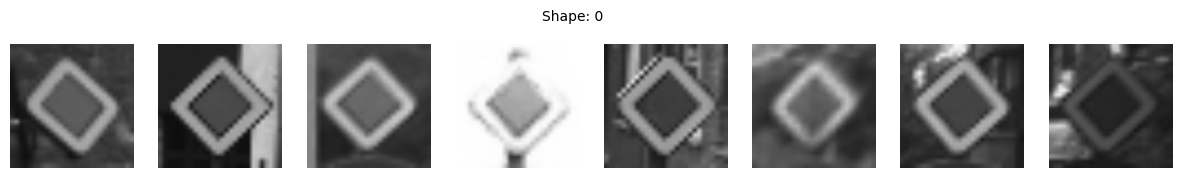

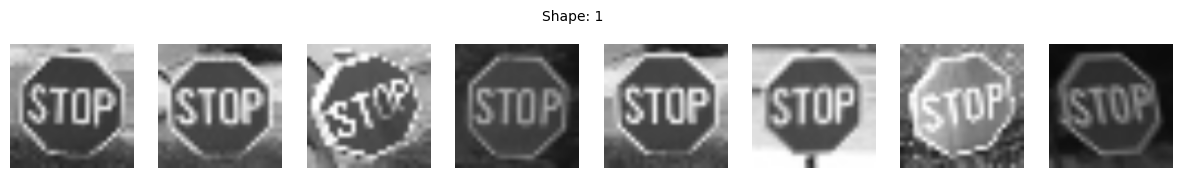

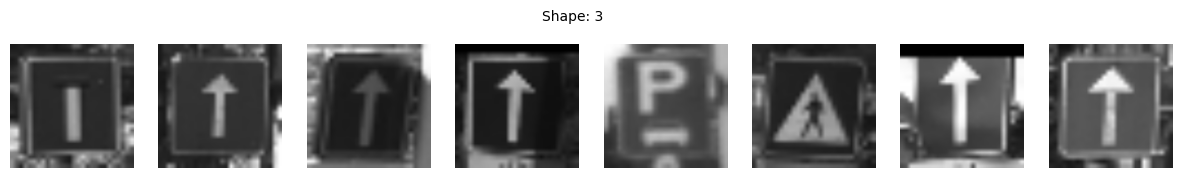

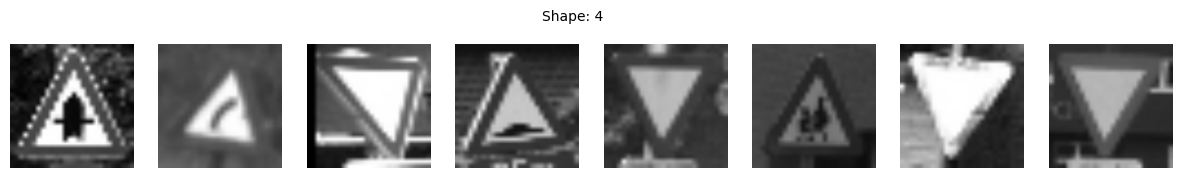

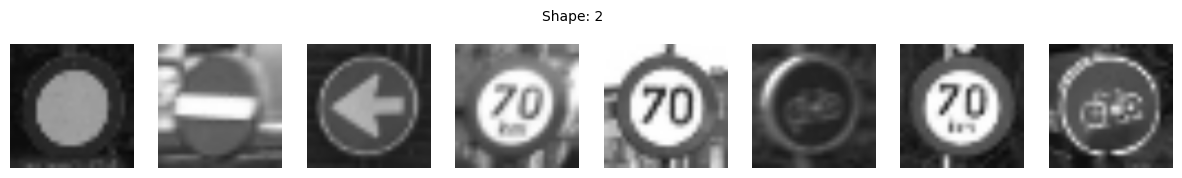

In [57]:
display_images(train, "Shape", 8)

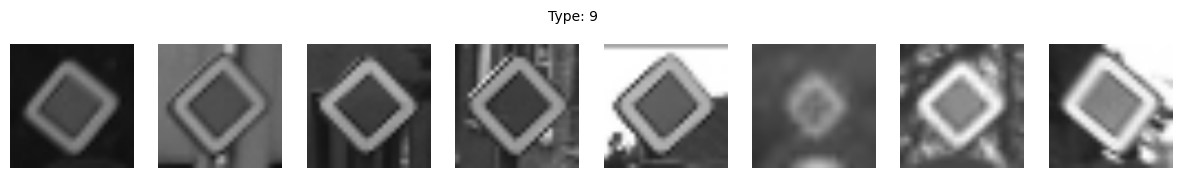

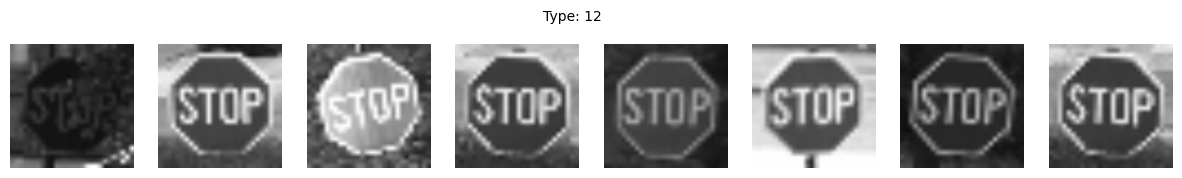

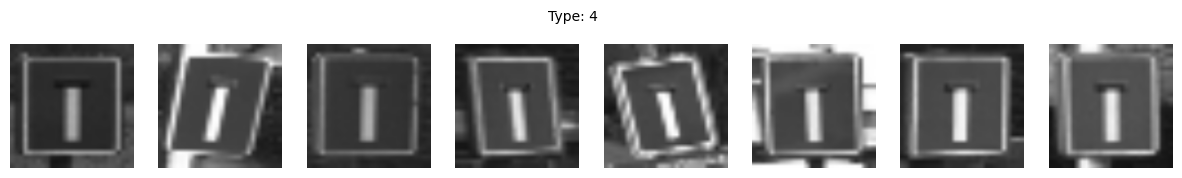

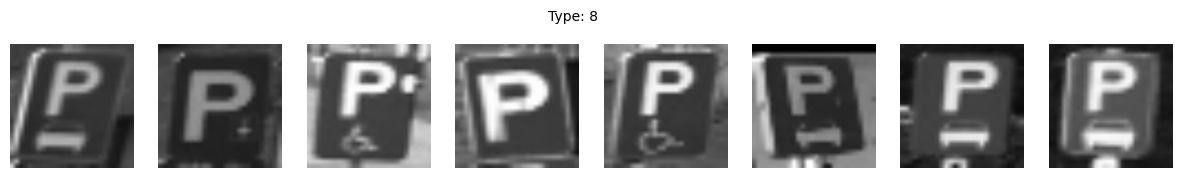

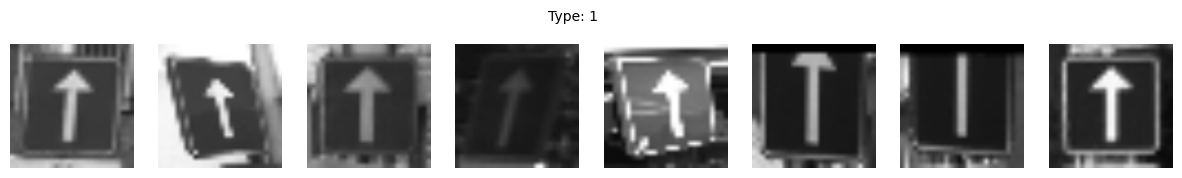

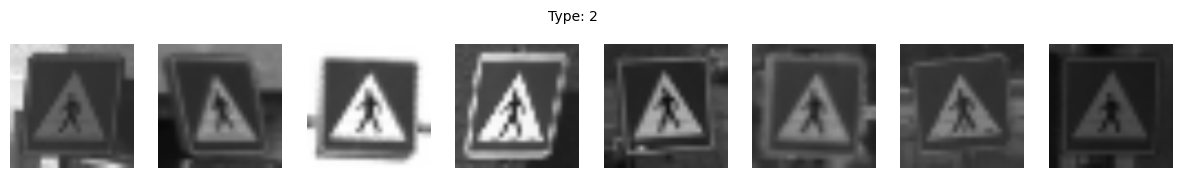

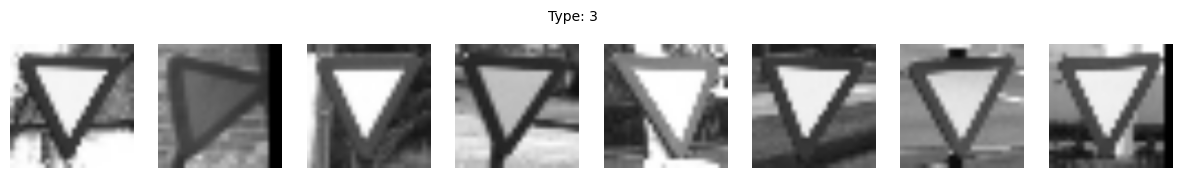

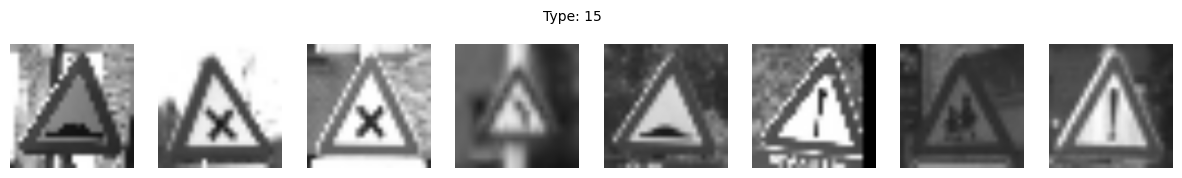

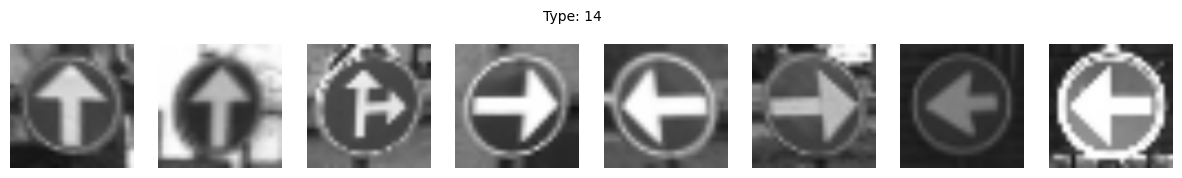

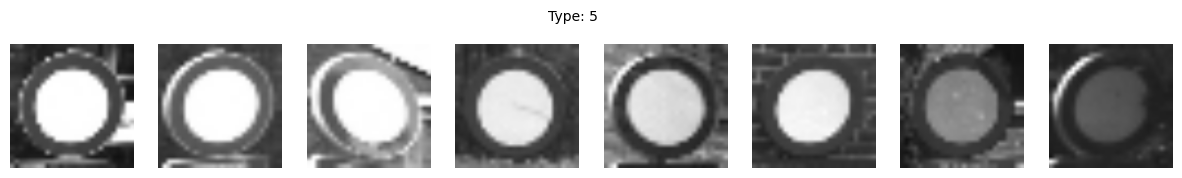

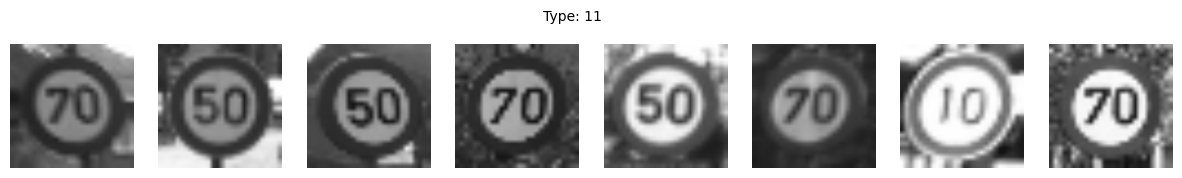

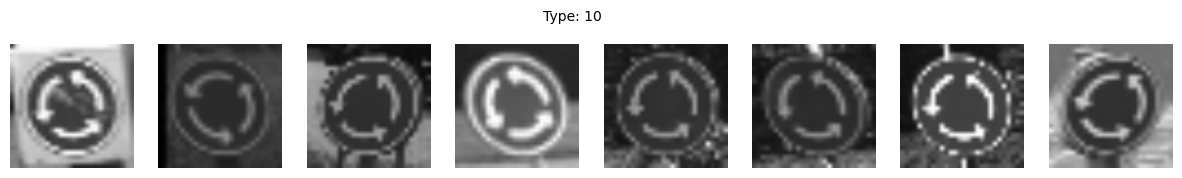

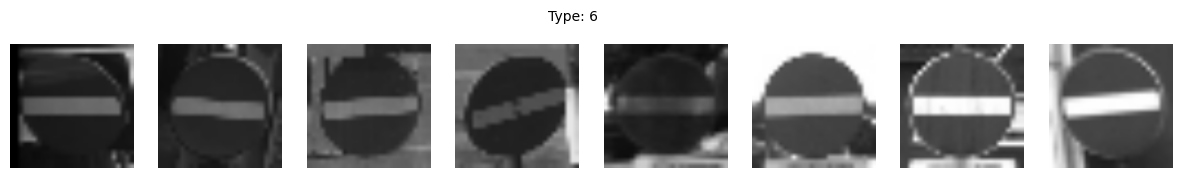

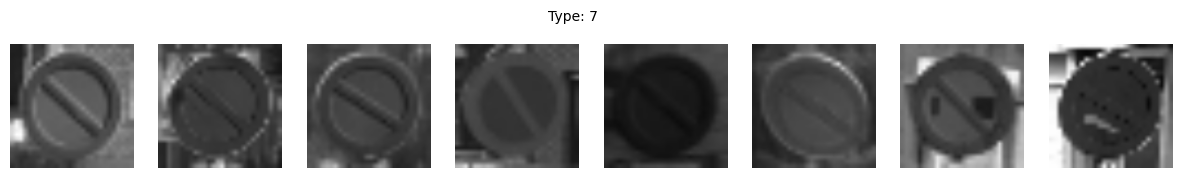

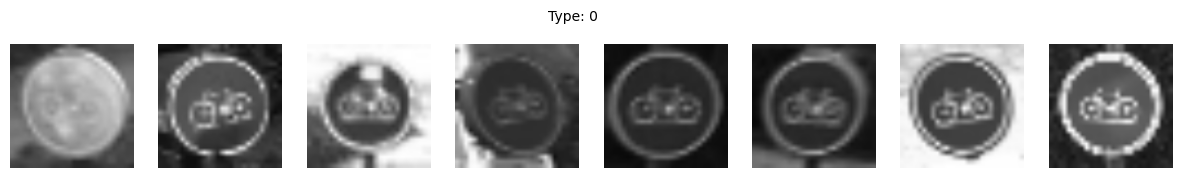

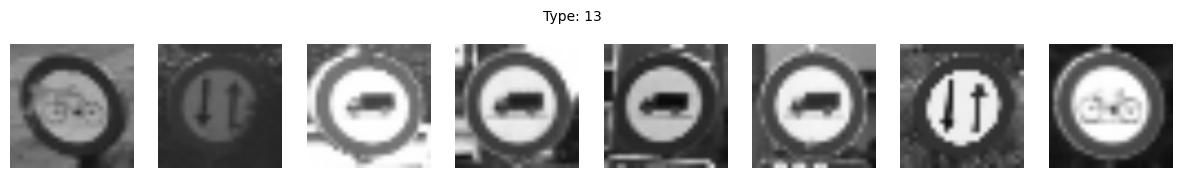

In [58]:
display_images(train, "Type", 8)

Encode class labels

In [20]:
def encoder(df):
    label_encoder = LabelEncoder()
    df['Shape'] = label_encoder.fit_transform(df['Shape'])
    df['Type'] = label_encoder.fit_transform(df['Type'])

    return df    

In [22]:
encoder(train)
encoder(test)
encoder(val)
train.head()

Path  Shape  Type
0  Dataset/train_test_val/train/round/speed/01269...      2    11
1  Dataset/train_test_val/train/round/speed/00224...      2    11
2  Dataset/train_test_val/train/round/speed/01003...      2    11
3  Dataset/train_test_val/train/round/speed/01842...      2    11
4  Dataset/train_test_val/train/round/speed/01238...      2    11

Handle Data Imbalance

In [23]:
def augment_data(df, image_batch_size, dest):
    
    images = []
    for image_path in df['Path']:
        img = plt.imread(image_path)
        images.append(img_to_array(img))
      

    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
    )

    for img in images:
        img = img.reshape((1,) + img.shape)
        for j, _ in enumerate(datagen.flow(img, save_to_dir=dest, batch_size=1, save_prefix='aug', save_format='png')):
            if j >= image_batch_size:
                break


In [24]:
def make_dir(src, dest):
    if (os.path.exists(dest)):
        if dest == 'Dataset/shape_aug/train':
            shutil.rmtree(r'./Dataset/shape_aug/train')
        elif dest == 'Dataset/type_aug/train':
            shutil.rmtree(r'./Dataset/type_aug/train')
    
    shutil.copytree(src, dest)

In [25]:
def start_shape_augmentation(train, choice, src, dest, batch_dict):
    make_dir(src=src, dest=dest)
    
    for key, [index, value, shape] in batch_dict.items():
        path = dest + '/' + shape + '/' + key
        augment_data(df=train[train.Type == index], image_batch_size=value, dest=path) 
    
    train_aug = fetch_images(dest + '/*/*/*.png')
    train_aug = encoder(train_aug)
    print(train_aug[choice].value_counts())
    visualise_data(train_aug)
    return train_aug

Shape
2    1054
1    1013
3     909
4     825
0     823
Name: count, dtype: int64


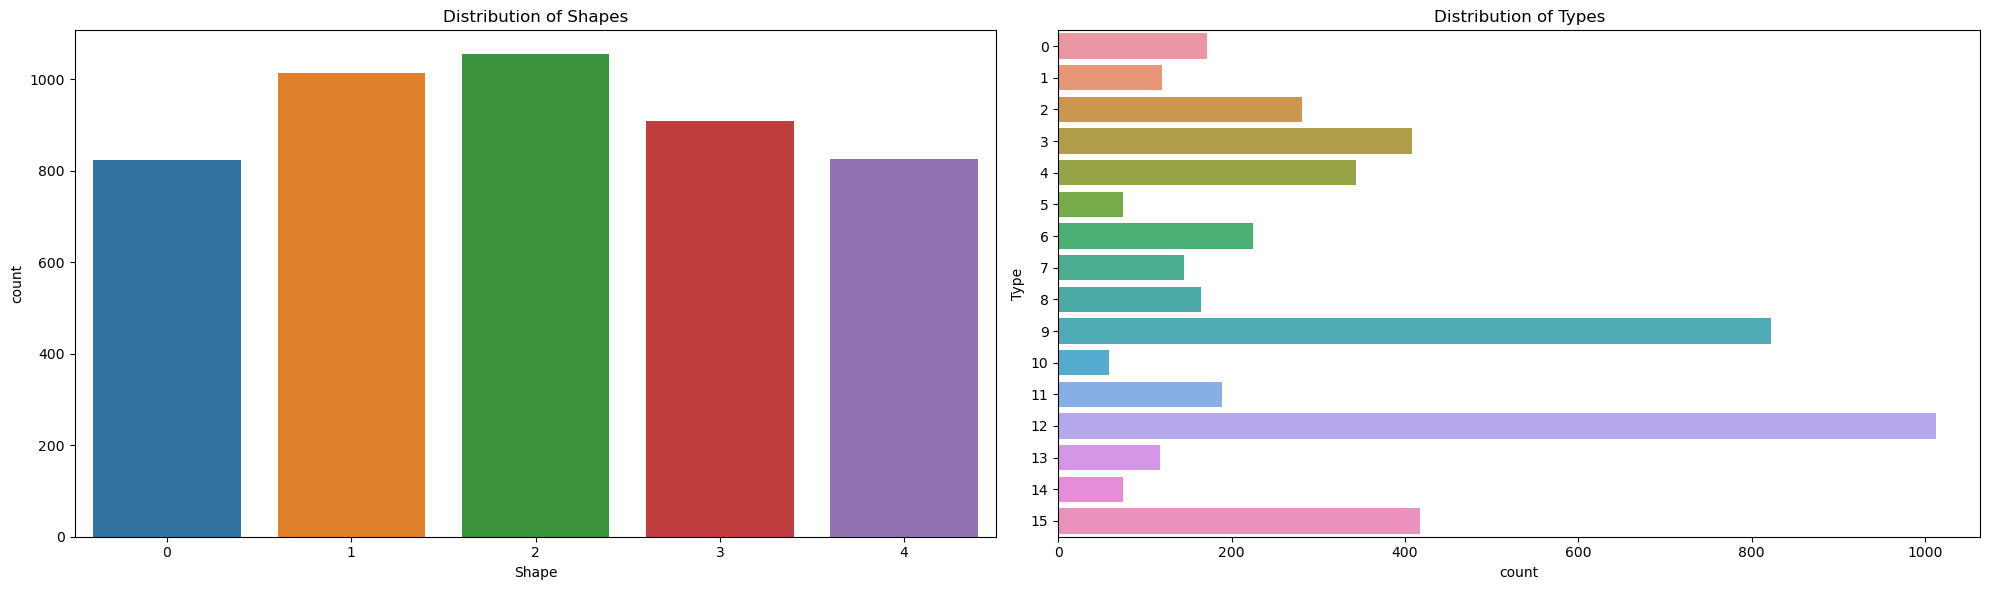

In [26]:
batch_dict_shape = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 41, 'hex'],
        'giveway': [3, 1, 'triangle'],
        'crossing': [2, 3, 'square'],
        'laneend': [4, 3, 'square'],
        'rightofway': [9, 3, 'diamond'],
    }
train_shape_aug = start_shape_augmentation(train, 'Shape', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/shape_aug/train', 
                                           batch_dict=batch_dict_shape)

Type
6     666
13    574
7     572
11    562
3     544
5     513
0     510
14    508
2     503
9     497
8     487
4     479
1     469
10    456
12    440
15    417
Name: count, dtype: int64


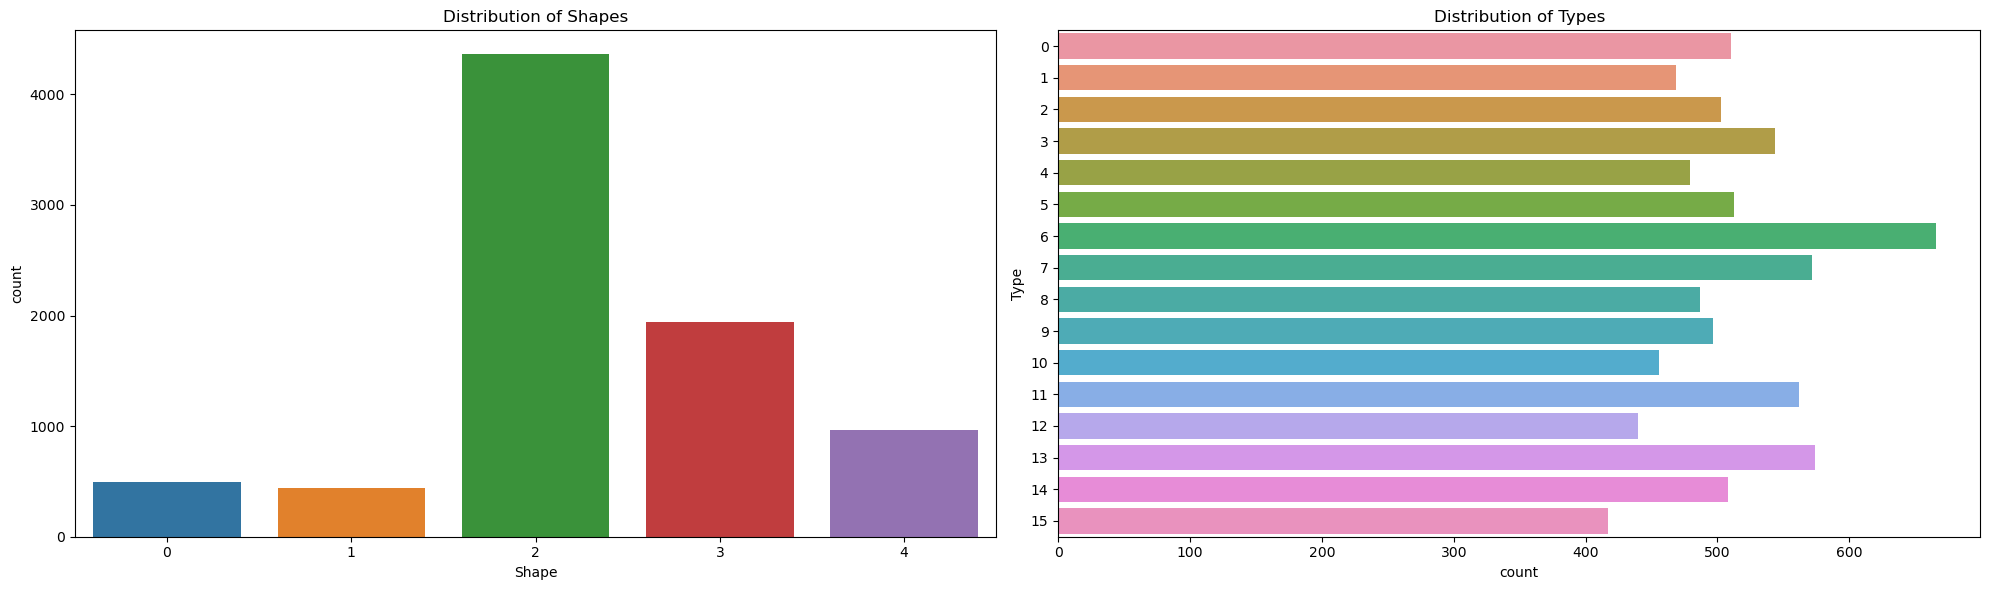

In [27]:
batch_dict_type = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 16, 'hex'],
        'crossing': [2, 7, 'square'],
        'roundabout': [10, 6, 'round'],
        'laneend': [4, 5, 'square'],
        'traveldirection': [14, 5, 'round'],
        'limitedtraffic': [5, 5, 'round'],
        'trafficdirective': [13, 3, 'round'],
        'continue': [1, 2, 'square'],
        'giveway': [3, 2, 'triangle'],
        'noparking': [7, 2, 'round'],
        'parking': [8, 1, 'square'],
        'rightofway': [9, 1, 'diamond'],
        'bicycle': [0, 1, 'round'],
        'speed': [11, 1, 'round'], 
        'noentry': [6, 1, 'round'],
    }
train_type_augmented = start_shape_augmentation(train, 'Type', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/type_aug/train', 
                                           batch_dict=batch_dict_type)

In [28]:
def calc_class_weights(df, label):
    unique_labels = train[label].unique()
    weights =  compute_class_weight(class_weight="balanced", classes=df[label].unique(), y=df[label].to_numpy())
    class_weights = dict(zip(unique_labels, weights))
    return class_weights

Generate Images for Training

In [85]:
def create_image_batches(df, batch_size, label, target_size=(28, 28), is_train = True):
        df[label] = df[label].astype('str')
        train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

        if is_train:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        color_mode="grayscale",
                        class_mode='categorical')
        else:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        shuffle=False,
                        color_mode="grayscale",
                        class_mode='categorical'
                        )
        
        return train_generator

In [103]:
# create image batches from train for Shape
shape_train_generator = create_image_batches(df=train, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
shape_val_generator = create_image_batches(df=val, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Shape
shape_aug_train_generator = create_image_batches(df=train_shape_aug, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 5 classes.
Found 735 validated image filenames belonging to 5 classes.
Found 2378 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2270 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(


In [112]:
type_train_generator = create_image_batches(df=train, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
type_val_generator = create_image_batches(df=val, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Type
type_aug_train_generator = create_image_batches(df=train_type_augmented, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 16 classes.
Found 735 validated image filenames belonging to 16 classes.
Found 2476 validated image filenames belonging to 16 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5724 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(


In [88]:
shape_test_generator = create_image_batches(df=test, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
type_test_generator = create_image_batches(df=test, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 750 validated image filenames belonging to 5 classes.


Found 750 validated image filenames belonging to 16 classes.


Model Development

In [89]:
OUTPUT_CLASSES_SHAPE = 5
OUTPUT_CLASSES_TYPE = 16
INPUT_DIM = (28, 28, 1)
# define metrics
METRIC = tf.keras.metrics.AUC(curve='PR', name='PR', from_logits=True)
LOSS_METRIC = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


print(
    f"Classes_Shape: {OUTPUT_CLASSES_SHAPE}\n"
    f"Classes_Type: {OUTPUT_CLASSES_TYPE}\n"
    f"Metric: {METRIC}\n"
    f"Loss Metric: {LOSS_METRIC}\n"
)

Classes_Shape: 5
Classes_Type: 16
Metric: <AUC name=PR>
Loss Metric: <keras.src.losses.losses.CategoricalCrossentropy object at 0x289c1a810>



In [33]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [34]:
def plot_performance(history, metric_label):
    val_metric_label = 'val_' + metric_label
    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history[metric_label], history.history[val_metric_label], 
                    metric_name = metric_label)

In [35]:
def tune_model(tuner, train_generator, val_generator, class_weights, epoch, tune_type):
    tuner.search(train_generator, validation_data=val_generator, class_weight=class_weights, epochs=epoch, verbose=0)
    best_hp = tuner.get_best_hyperparameters()[0]
    tuned_val = best_hp.get(tune_type)
    print(f"Best {tune_type}: {tuned_val}")
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epoch, verbose=0, class_weight=class_weights)
    plot_performance(history=history, metric_label='PR')
    return model

Fetch class weights

In [36]:
shape_weights = calc_class_weights(df=train, label='Shape')
shape_weights

{'2': 0.42011385199240986,
 '1': 17.712,
 '3': 1.0773722627737226,
 '0': 2.620118343195266,
 '4': 0.7978378378378378}

In [37]:
type_weights = calc_class_weights(df=train, label='Type')
type_weights

{'11': 0.7321428571428571,
 '0': 0.8092105263157895,
 '14': 1.8699324324324325,
 '10': 2.3857758620689653,
 '13': 1.1826923076923077,
 '6': 0.615,
 '7': 0.9543103448275863,
 '5': 1.845,
 '12': 5.535,
 '1': 1.1628151260504203,
 '2': 2.4276315789473686,
 '4': 1.9767857142857144,
 '8': 0.8386363636363636,
 '9': 0.8187869822485208,
 '15': 0.3318345323741007,
 '3': 1.002717391304348}

### Models

Base MLP

In [90]:
def baseline_mlp(output_class):

    
        INPUT_DIM = (28,28,1)
        HIDDEN_LAYER_DIM = 400
        OUTPUT_CLASSES = output_class
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE

        model = tf.keras.Sequential([
        
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
        ])

        return model

Base VGG

In [39]:
def build_model_VGG(input_shape, output_classes, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same', input_shape=input_shape),
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
   
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(output_classes, activation='softmax'),
    ])

    return model

Tuneable VGG with L2 Regularization

In [94]:
def build_model_VGG_reg_shape(hp):    
    lambda_value = hp.Choice('lambda', [0.006407366308178109, 0.018037870215070927, 0.001, 0.0001])
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

In [95]:
def build_model_VGG_reg_type(hp):    
    lambda_value = hp.Choice('lambda', [0.1, 0.01, 0.001, 0.0001])
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

Tunable VGG with Dropout Regularization

In [92]:
def build_model_VGG_dropout_shape(hp):    
    # choose best lmabda value from tuned lambda
    if not augmented:
        lambda_value = 0.018037870215070927
    else:
        lambda_value = 0.006407366308178109

    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

In [98]:
def build_model_VGG_dropout_type(hp):    
    # choose best lmabda value from tuned lambda
    if not augmented:
        lambda_value = 0.001
    else:
        lambda_value = 0.0001

    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

### Tuners

Lambda Tuner

In [89]:
# Initialize the l2 tuner
def init_lambda_tuner(choice):
    if (os.path.exists('lambda_tuning')):
        shutil.rmtree(r'./lambda_tuning')
    
    if choice == 'Shape':
        model_builder = build_model_VGG_reg_shape
    else:
        model_builder = build_model_VGG_reg_type

    lambda_tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=3,
        project_name='lambda_tuning')
    return lambda_tuner

Dropout Tuner

In [90]:
# Initialize the droput tuner
def init_dropout_tuner(choice):
    if (os.path.exists('dropout_tuning')):
        shutil.rmtree(r'./dropout_tuning')
    
    if choice == 'Shape':
        model_builder = build_model_VGG_dropout_shape
    else:
        model_builder = build_model_VGG_dropout_type
    
    dropout_tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=4,
        project_name='dropout_tuning')
    return dropout_tuner

In [74]:
def compile_model(model, optimiser='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    model.compile(optimizer=optimiser, loss=loss, metrics=metrics)
    return model

In [75]:
def train_model(model, train_generator, val_generator, epochs=50, class_weights=None):
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, class_weight=class_weights, verbose=0)
    return history

Baseline Model

In [80]:
def mlp_pipeline(train, val, output_class, metric_label, optimiser, activation, epoch, class_weights):
    model = baseline_mlp(output_class)
    model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
    history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
    plot_performance(history=history, metric_label=metric_label)
    return model

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


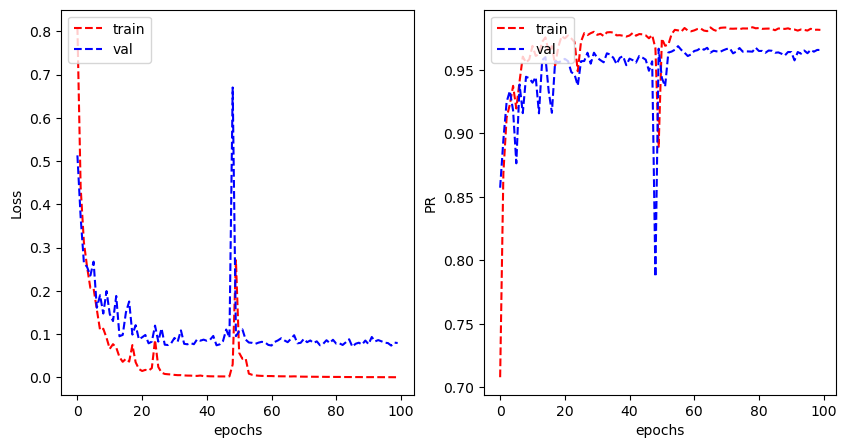

In [91]:
baseline_mlp_model_shape = mlp_pipeline(train = shape_train_generator, 
                              val = shape_val_generator, 
                              output_class= OUTPUT_CLASSES_SHAPE,
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [132]:
baseline_mlp_model_shape.save('models/shape/baseline_mlp_model_shape.keras')

Convolutional Neural Network (CNN)

In [72]:
def pipeline(train, val, metric_label, optimiser, activation, epoch, class_weights, output_classes):
    model = build_model_VGG(input_shape=INPUT_DIM, output_classes=output_classes, activation=activation)
    model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
    history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
    plot_performance(history=history, metric_label=metric_label)
    return model


VGG with Adam Optimiser

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


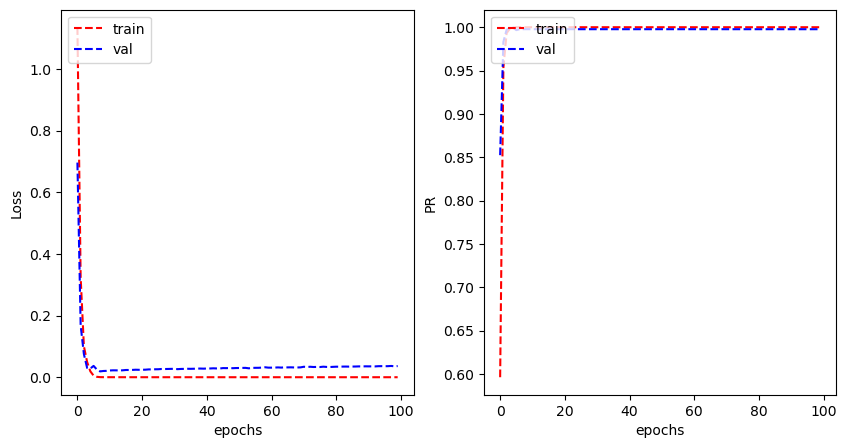

In [49]:
model_VGG_base_adam_shape = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='adam',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_SHAPE,
                          class_weights=None)

VGG with SGD Optimiser

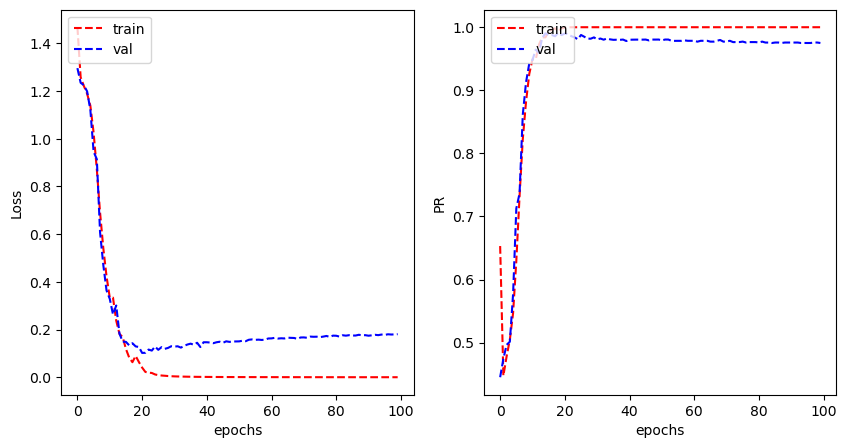

In [50]:
model_VGG_base_SGD_shape = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_SHAPE, 
                          class_weights=None)

In [51]:
model_VGG_base_SGD_shape.save('models/shape/model_VGG_base_SGD_shape.keras')

Class Re-Weighting

Baseline

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


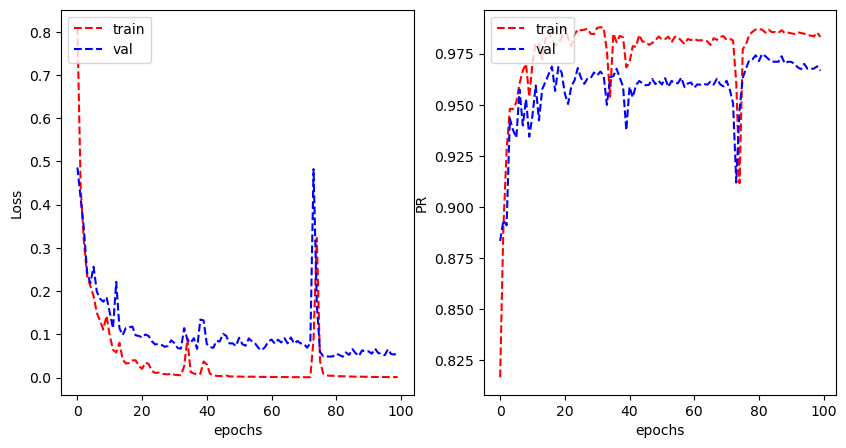

In [95]:
baseline_mlp_model_shape_reweighted = mlp_pipeline(train = shape_train_generator, 
                              val = shape_val_generator, 
                              output_class= OUTPUT_CLASSES_SHAPE,
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=shape_weights)

In [133]:
baseline_mlp_model_shape_reweighted.save('models/shape/baseline_mlp_model_shape_reweighted.keras')

VGG with Class Re-Weighting

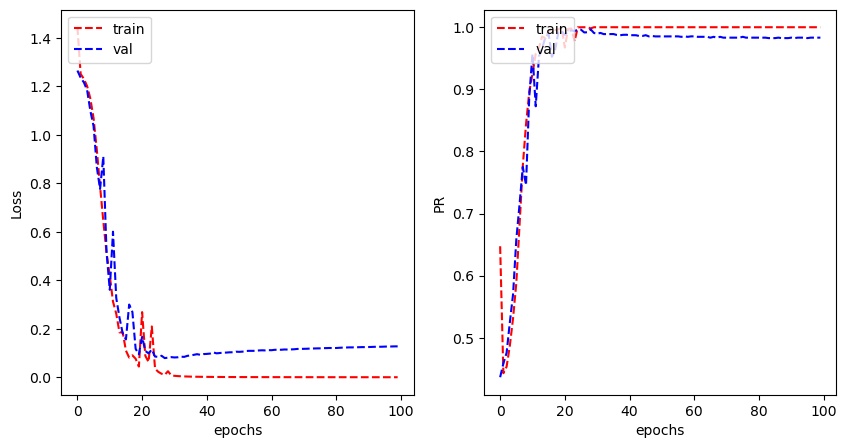

In [52]:
model_VGG_base_SGD_shape_reweighted = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_SHAPE,
                          class_weights=shape_weights)

In [53]:
model_VGG_base_SGD_shape_reweighted.save('models/shape/model_VGG_base_SGD_shape_reweighted.keras')

L2 Regularisation

Best lambda: 0.018037870215070927


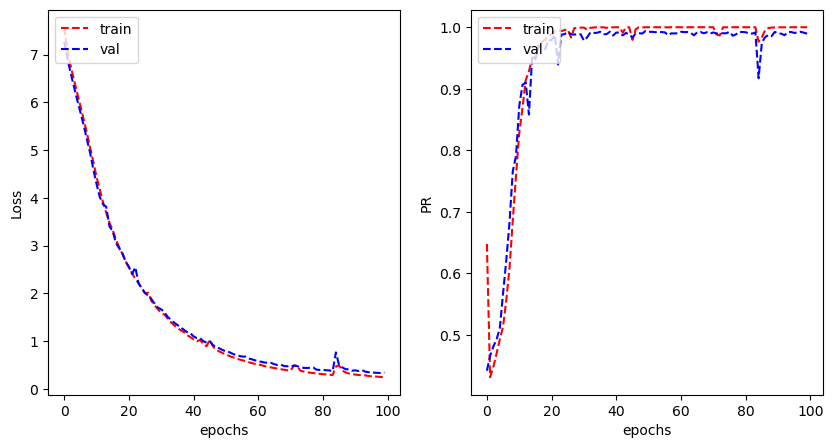

In [54]:
lambda_tuner = init_lambda_tuner(choice='Shape')
best_model_l2_shape = tune_model(lambda_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [55]:
best_model_l2_shape.save('models/shape/best_model_l2_shape.keras')

Dropout Regularisation

Best dropout_rate: 0.2


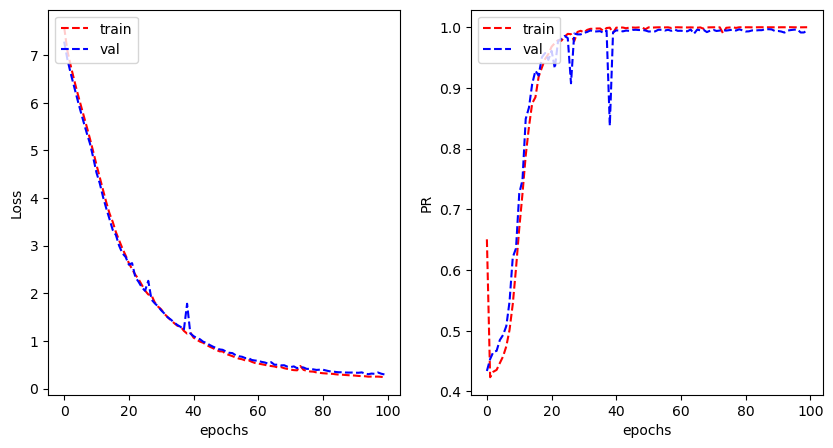

In [56]:
dropout_tuner = init_dropout_tuner(choice='Shape')
best_model_droput_shape = tune_model(dropout_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [57]:
best_model_droput_shape.save('models/shape/best_model_droput_shape.keras')

Augmented Data

In [99]:
augmented = True

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


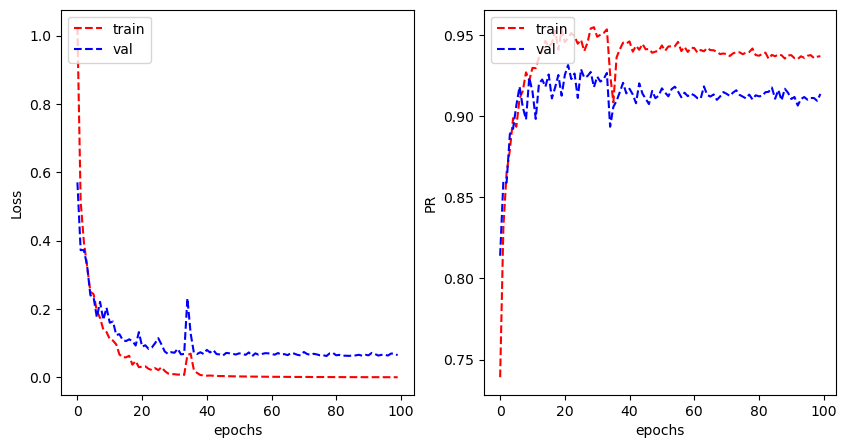

In [104]:
baseline_mlp_model_shape_aug = mlp_pipeline(train = shape_aug_train_generator, 
                              val = shape_val_generator, 
                              output_class= OUTPUT_CLASSES_SHAPE,
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [134]:
baseline_mlp_model_shape_aug.save('models/shape/baseline_mlp_model_shape_aug.keras')

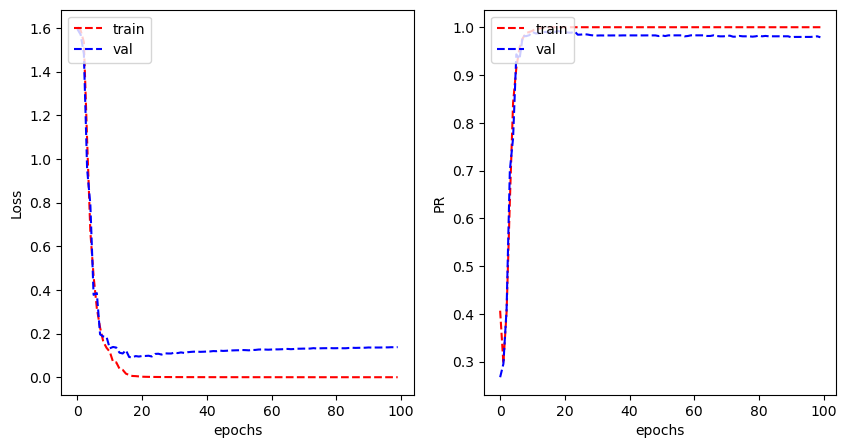

In [58]:
model_VGG_base_SGD_shape_aug = pipeline(shape_aug_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [59]:
model_VGG_base_SGD_shape_aug.save('models/shape/model_VGG_base_SGD_shape_aug.keras')

Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best lambda: 0.006407366308178109


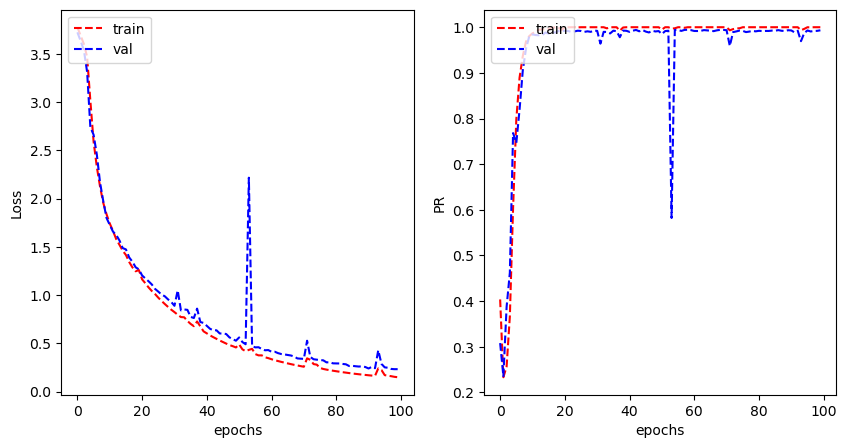

In [66]:
lambda_tuner = init_lambda_tuner(choice='Shape')
best_model_l2_shape_aug = tune_model(lambda_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [67]:
best_model_l2_shape_aug.save('models/shape/best_model_l2_shape_aug.keras')

Dropout

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best dropout_rate: 0.30000000000000004


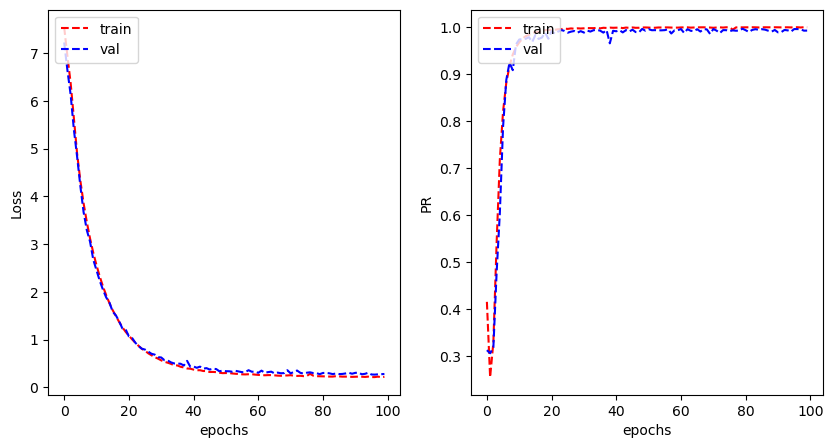

In [68]:
dropout_tuner = init_dropout_tuner(choice='Shape')
best_model_dropout_shape_aug = tune_model(dropout_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [69]:
best_model_dropout_shape_aug.save('models/shape/best_model_droput_shape_aug.keras')

Type

In [100]:
augmented = False

Baseline

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


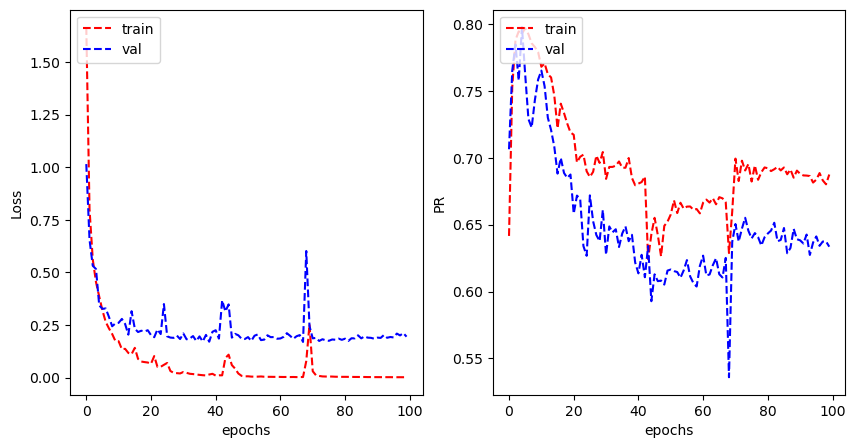

In [106]:
baseline_mlp_type = mlp_pipeline(train = type_train_generator, 
                              val = type_val_generator, 
                              output_class= OUTPUT_CLASSES_TYPE,
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [135]:
baseline_mlp_type.save('models/type/baseline_mlp_type.keras')

Base SGD Optimiser

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as

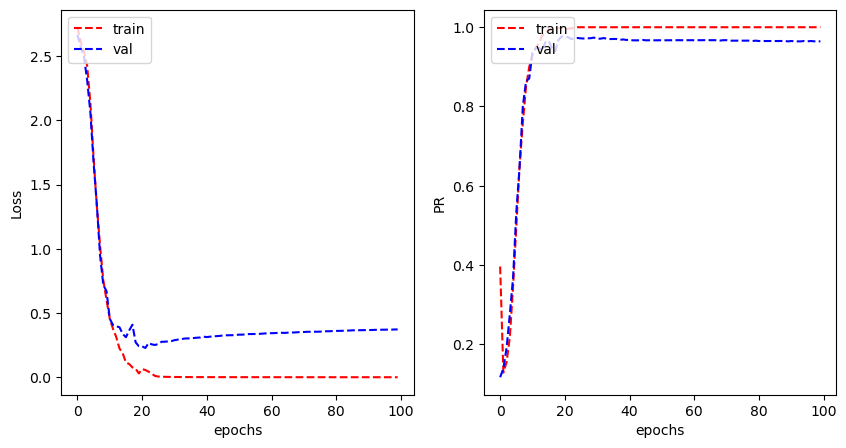

In [73]:
model_VGG_base_SGD_type = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=None)

In [74]:
model_VGG_base_SGD_type.save('models/type/model_VGG_base_SGD_type.keras')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


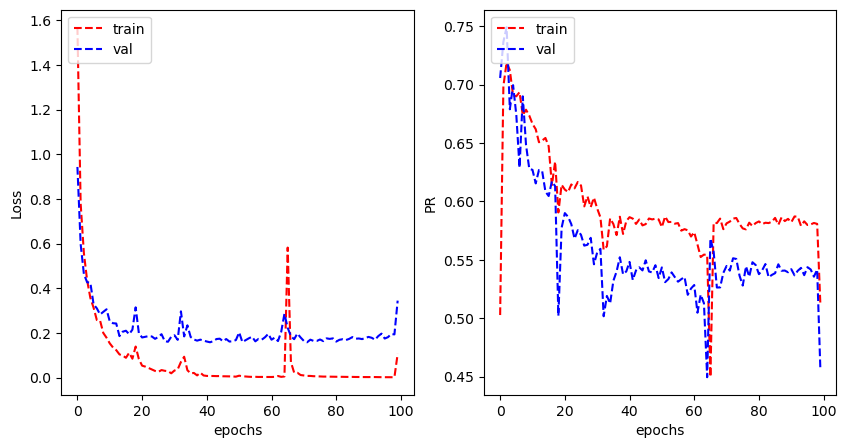

In [108]:
baseline_mlp_type_reweighted = mlp_pipeline(train = type_train_generator, 
                              val = type_val_generator, 
                              output_class= OUTPUT_CLASSES_TYPE,
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=type_weights)

In [136]:
baseline_mlp_type_reweighted.save('models/type/baseline_mlp_type_reweighted.keras')

Reweighted SGD Optimiser

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


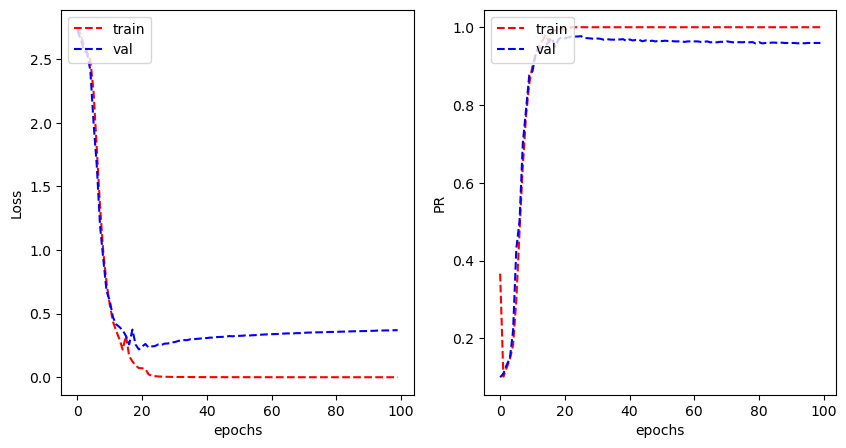

In [75]:
model_VGG_base_SGD_type_reweighted = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=type_weights)

In [76]:
model_VGG_base_SGD_type_reweighted.save('models/type/model_VGG_base_SGD_type_reweighted.keras')

L2 Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best lambda: 0.001


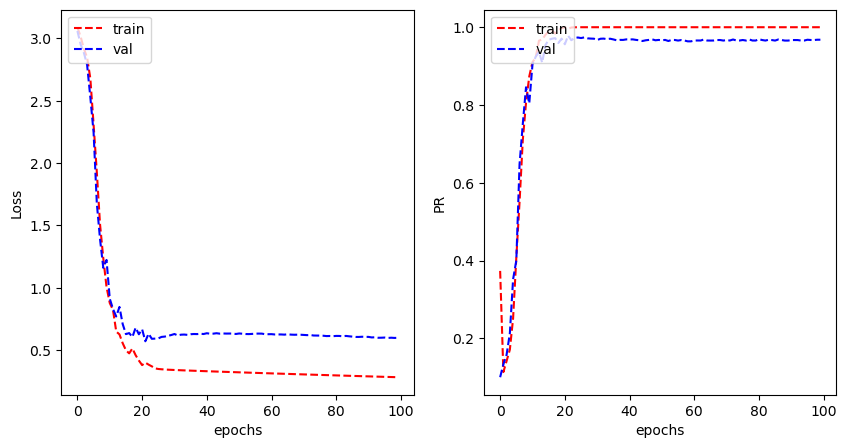

In [93]:
lambda_tuner = init_lambda_tuner(choice='Type')
best_model_l2_type = tune_model(lambda_tuner, type_train_generator, type_val_generator, type_weights, 100, 'lambda')

In [104]:
best_model_l2_type.save('models/type/best_model_l2_type.keras')

Dropout Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best dropout_rate: 0.4


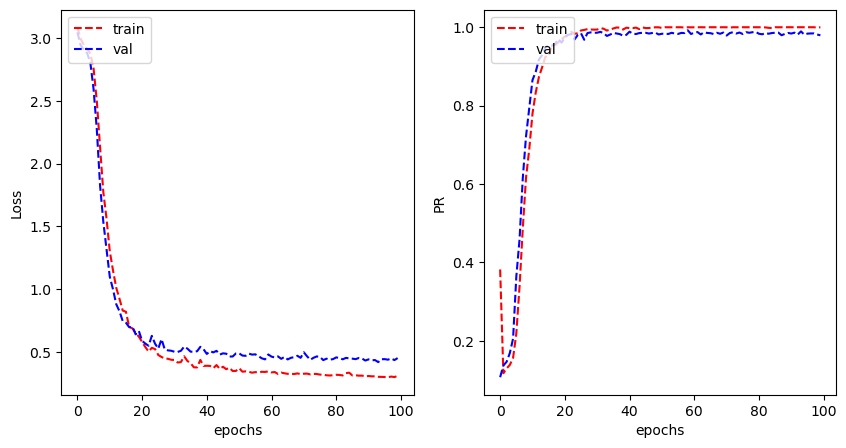

In [101]:
dropout_tuner = init_dropout_tuner(choice='Type')
best_model_droput_type = tune_model(dropout_tuner, type_train_generator, type_val_generator, type_weights, 100, 'dropout_rate')

In [103]:
best_model_droput_type.save('models/type/best_model_droput_type.keras')

Augmented Data

In [108]:
augmented = True

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


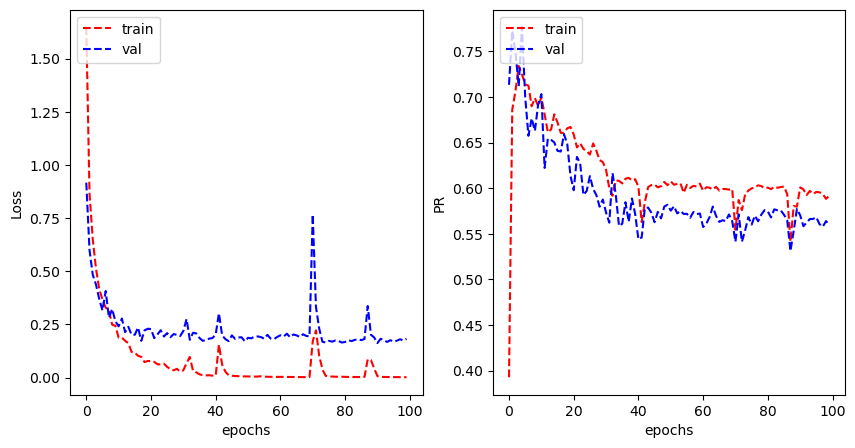

In [113]:
baseline_mlp_type_aug = mlp_pipeline(train = type_aug_train_generator, 
                              val = type_val_generator, 
                              output_class= OUTPUT_CLASSES_TYPE,
                              metric_label='PR',
                              optimiser='adam',
                              activation='relu',
                              epoch=100,
                              class_weights=None)

In [137]:
baseline_mlp_type_aug.save('models/type/baseline_mlp_type_aug.keras')

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


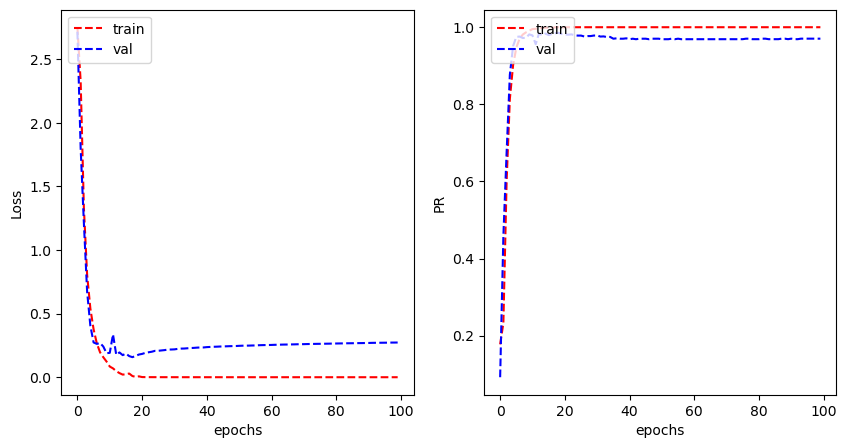

In [102]:
model_VGG_base_SGD_type_aug = pipeline(type_aug_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=None)

In [105]:
model_VGG_base_SGD_type_aug.save('models/type/model_VGG_base_SGD_type_aug.keras')

L2 Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best lambda: 0.0001


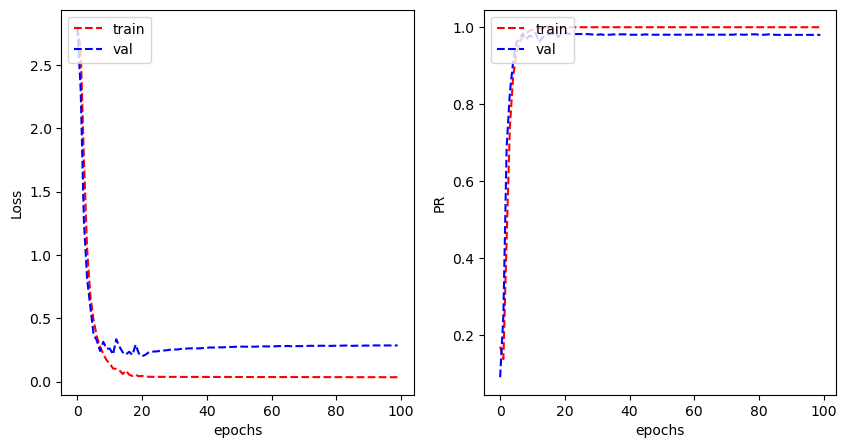

In [106]:
lambda_tuner = init_lambda_tuner(choice='Type')
best_model_l2_type_aug = tune_model(lambda_tuner, type_aug_train_generator, type_val_generator, None, 100, 'lambda')

In [107]:
best_model_l2_type_aug.save('models/type/best_model_l2_type_aug.keras')

Dropout Regularisation

In [ ]:
dropout_tuner = init_dropout_tuner(choice='Type')
best_model_droput_type_aug = tune_model(dropout_tuner, type_aug_train_generator, type_val_generator, None, 100, 'dropout_rate')

In [ ]:
best_model_droput_type_aug.save('models/type/best_model_droput_type_aug.keras')

### Testing

In [115]:
label_names_type = {'bicycle':0, 'continue':1, 'crossing':2, 'giveway':3, 'laneend':4, 'limitedtraffic':5,
'noentry': 6, 
'noparking': 7,
'parking': 8, 'rightofway': 9, 'roundabout': 10,'speed': 11, 'stop': 12, 'trafficdirective': 13, 'traveldirection': 14, 'warning': 15}

In [116]:
label_names_shape = {'diamond':0, 'hex':1, 'square':2, 'triangle':3, 'round':4 }

In [246]:
def load_keras_models(model_dir):
    models = {}
    for model_name in os.listdir(model_dir):
        if model_name.endswith('.keras'):  
            model_path = os.path.join(model_dir, model_name)
            models[model_name] = load_model(model_path)
    return models


In [149]:
def evaluate_models(models, test_generator):
    results = {}
    for model_name, model in models.items():
        loss, accuracy = model.evaluate(test_generator)
        results[model_name] = {'loss': loss, 'accuracy': accuracy}
    return results


In [242]:
def evaluate_models(models, test_generator):
    results = {}
    for model_name, model in models.items():
        
        # Evaluate the model to get loss and accuracy
        print(model)
        loss, accuracy = model.evaluate(test_generator)
        
        # Get predictions
        test_generator.reset()
        predictions = model.predict(test_generator)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = test_generator.classes
        class_labels = list(test_generator.class_indices.keys())
        
        # Calculate confusion matrix, precision, recall, and F1 score
        conf_matrix = confusion_matrix(true_classes, predicted_classes)
        precision = precision_score(true_classes, predicted_classes, average='macro')
        recall = recall_score(true_classes, predicted_classes, average='macro')
        f1 = f1_score(true_classes, predicted_classes, average='macro')
        pr = (precision + recall) / 2
        
        results[model_name] = {
            'loss': loss,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'pr': pr
        }
    return results


In [244]:
def display_all_models(results):
    for model_name, metrics in results.items():
        print(f'Model: {model_name}')
        print(f"Loss: {metrics['loss']}, PR: {metrics['pr']}")
        print(f"Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1 Score: {metrics['f1_score']}")
        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print("-" * 50)

Testing with the test_data - Shape 

In [245]:
model_dir = 'models/shape'

models = load_keras_models(model_dir)
results = evaluate_models(models, shape_test_generator)

display_all_models(results)

<Sequential name=sequential_1, built=True>
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - PR: 0.9963 - loss: 0.2807
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
<Sequential name=sequential_7, built=True>
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - PR: 0.9566 - loss: 0.1233
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
<Sequential name=sequential_1, built=True>
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - PR: 0.9912 - loss: 0.3388
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
<Sequential name=sequential_1, built=True>
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - PR: 0.9905 - loss: 0.2410
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
<Sequential name=sequential_4, built=True>


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - PR: 0.9897 - loss: 0.0862
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
<Sequential name=sequential_8, built=True>
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - PR: 0.9542 - loss: 0.1096
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
<Sequential name=sequential_3, built=True>


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - PR: 0.9743 - loss: 0.1759
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
<Sequential name=sequential_14, built=True>
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - PR: 0.8899 - loss: 0.1555
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
<Sequential name=sequential_2, built=True>


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - PR: 0.9886 - loss: 0.0997
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
<Sequential name=sequential_1, built=True>
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - PR: 0.9895 - loss: 0.3098
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Model: best_model_droput_shape.keras
Loss: 0.3116131126880646, PR: 0.20894809799848996
Precision: 0.20958335618304033, Recall: 0.20831283981393955, F1 Score: 0.208862909509718
Confusion Matrix:
[[  7   1  26  11  12]
 [  1   0   4   1   4]
 [ 21   0 174  69  92]
 [  8   4  70  25  34]
 [ 14   5  85  35  47]]
--------------------------------------------------
Model: baseline_mlp_model_shape.keras
Loss: 0.12840379774570465, PR: 0.21113055058736488
Precision: 0.21082711763638007, Recall: 0.2114339835383497, F1 Score: 0.21112024718544725
Confusion Matrix:
[[  3   0  23  17  14]
 [  2   0   3   1   4]
 [ 28   2 190  59  77]
 [  7   3  58  30  43]
 [ 14   4  85  35  48]]
--------------------------------------------------
Model: best_mode

Testing with the test_data - Type 

In [163]:
model_dir = 'models/type'

models = load_keras_models(model_dir)
results = evaluate_models(models, type_test_generator)

display_all_models(results)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - PR: 0.9742 - loss: 0.5210
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - PR: 0.4659 - loss: 0.4296
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - PR: 0.9807 - loss: 0.2116
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - PR: 0.9653 - loss: 0.2985
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - PR: 0.6278 - loss: 0.2239
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - PR: 0.9725 - loss: 0.3542
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - PR: 0.9591 - loss: 0.3684
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - PR: 0.5683 - loss: 0.2591
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - PR: 0.9751 - loss: 0.1763
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - PR: 0.9868 - loss: 0.4301
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Model: best_model_l2_type.keras
Loss: 0.5772484540939331, PR: 0.06822999197346663
Precision: 0.06833107532662275, Recall: 0.06812890862031051, F1 Score: 0.06819229085827264
Confusion Matrix:
[[ 5  0  2  3  0  2  0 19  2  3  0  4  6  4  4  3]
 [ 4  2  0  2  0  2  1  7  1  5  1  0  4  5  5  2]
 [ 1  3  0  1  1  1  0  5  0  2  1  0  2  2  0  2]
 [ 7  3  0  7  0  2  1 14  3  6  1  0  3  4  7  6]
 [ 2  0  1  0  0  0  0  3  0  1  0  0  0  1  1  1]
 [ 5  2  0  5  0  1  0  8  0  3  0  2  4  2  3  4]
 [ 3  2  2  2  0  1  3  0  1  1  0  2  3  1  2  3]
 [ 5 13  5 17  2  6  5 27  4 10  2  4 12  7 11  9]
 [ 1  1  0  1  0  1  1  3  0  0  2  2  3  3  1  0]
 [ 5  3  1  2  0  3  4  4  1  3  5  3  5  3  0  5]
 [ 1  0  1  5  0  3  0  2  0  2  2  1  2  2  1  3]
 [ 4  1  1  1  0  1  0  3  0  5 

Importing the images from external data for testing

In [223]:
def fetch_images_external(root_path):
    image_list = []
    
    allowed_extensions = ['jpg', 'jpeg', 'png', 'webp', 'gif', 'bmp', 'JPG', 'JPEG', 'PNG', 'WEBP', 'GIF', 'BMP']
    
    glob_pattern = f"{root_path}/*/*/*.*"  

    for filepath in glob.glob(glob_pattern, recursive=True):
        
        if filepath.lower().split('.')[-1] in allowed_extensions:
            shape = filepath.split('/')[-3]  
            types = filepath.split('/')[-2]  
            image_list.append((filepath, shape, types))
    
    df = build_df_from_image_list(image_list)
    return df

In [234]:
test_data_external = fetch_images_external('Dataset/evaluation/test_data_external')

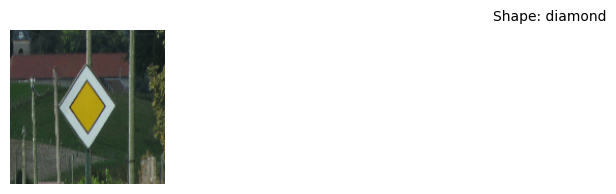

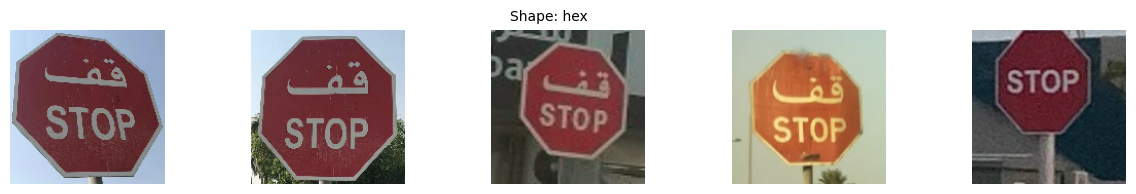

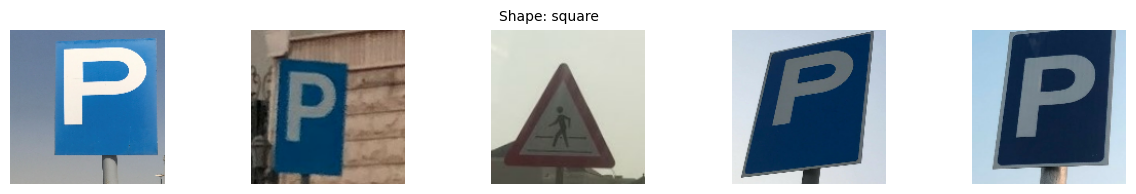

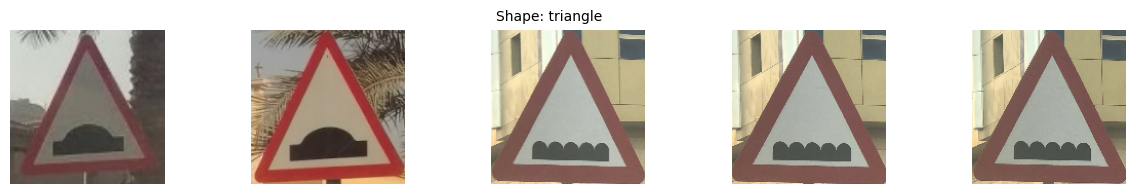

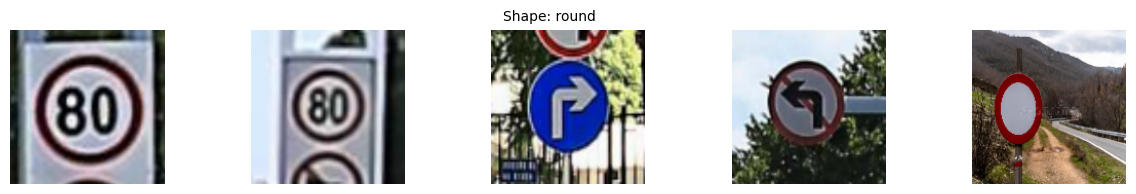

In [235]:
display_images(test_data_external, "Shape", 5)

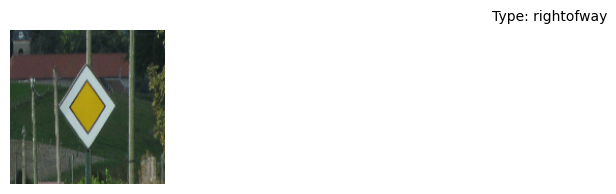

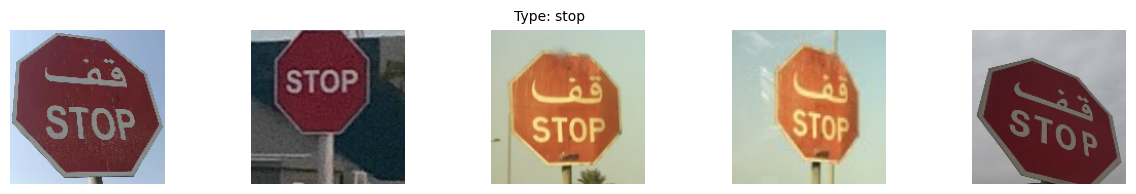

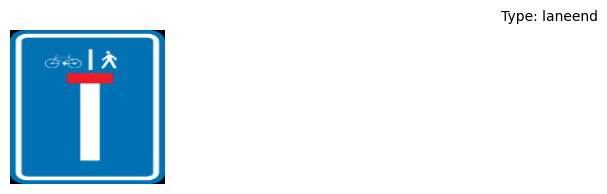

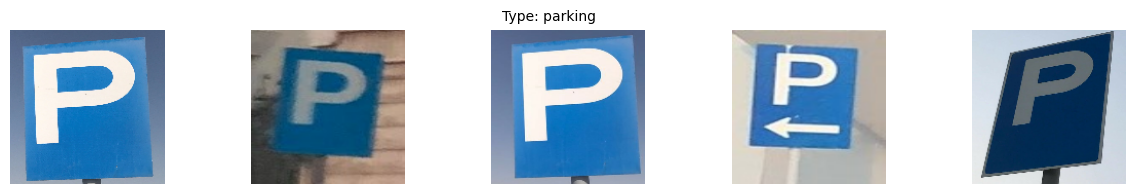

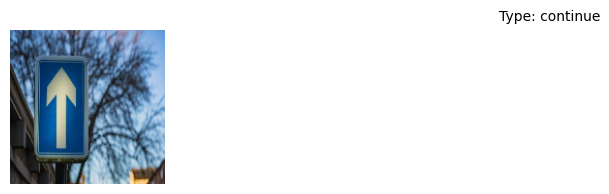

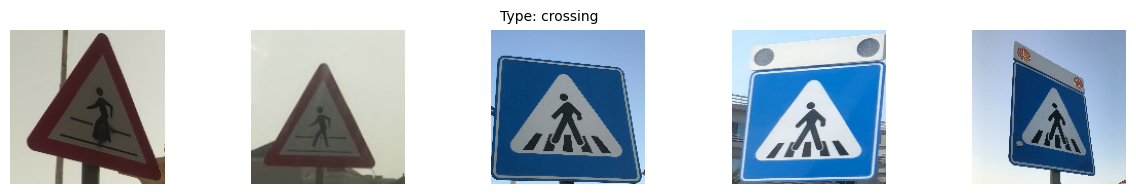

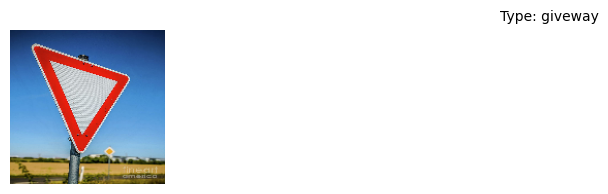

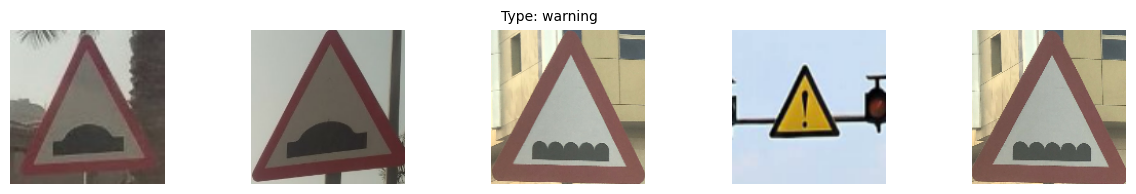

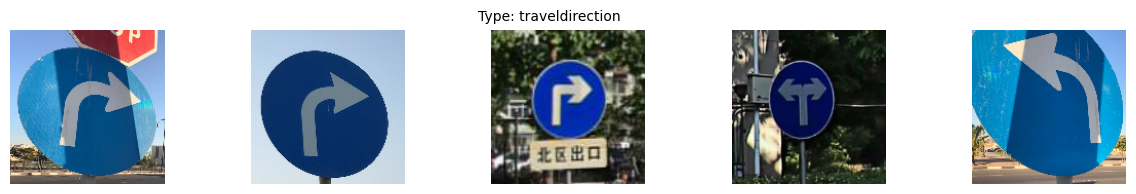

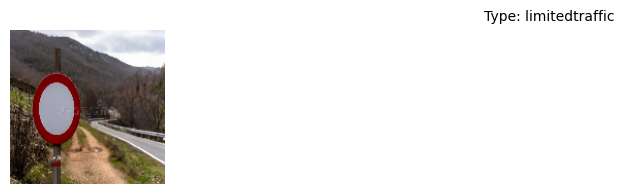

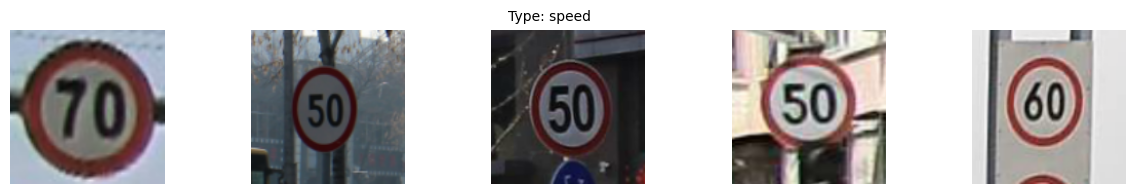

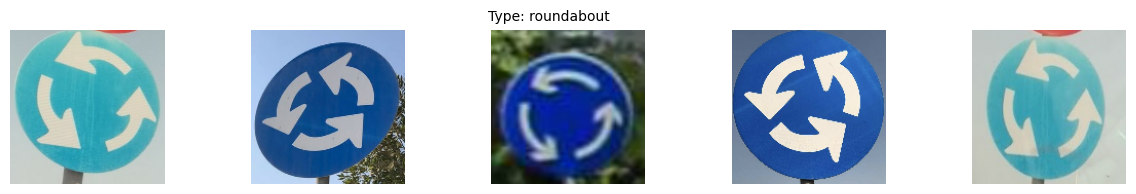

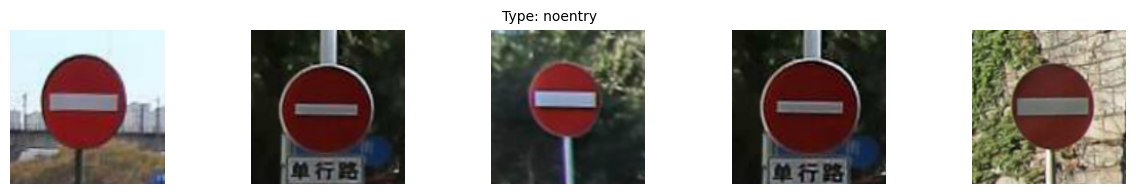

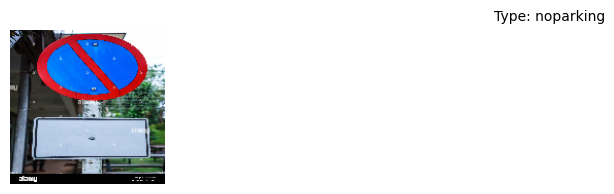

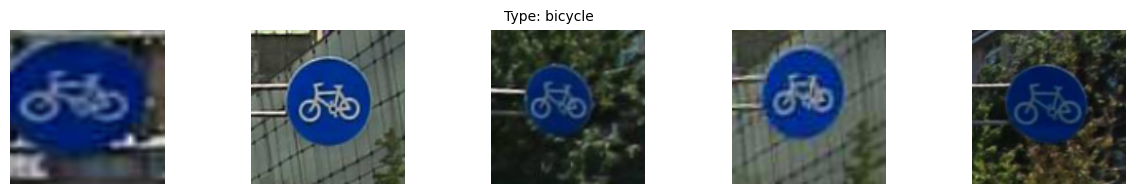

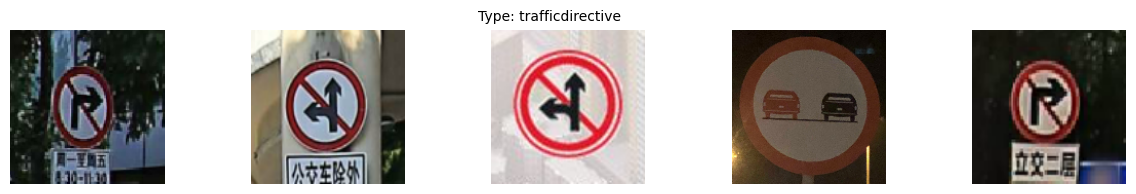

In [236]:
display_images(test_data_external, "Type", 5)

In [237]:
encoder(test_data_external)

Path  Shape  Type
0    Dataset/evaluation/test_data_external/diamond/...      0     9
1    Dataset/evaluation/test_data_external/hex/stop...      1    12
2    Dataset/evaluation/test_data_external/hex/stop...      1    12
3    Dataset/evaluation/test_data_external/hex/stop...      1    12
4    Dataset/evaluation/test_data_external/hex/stop...      1    12
..                                                 ...    ...   ...
704  Dataset/evaluation/test_data_external/round/tr...      2    13
705  Dataset/evaluation/test_data_external/round/tr...      2    13
706  Dataset/evaluation/test_data_external/round/tr...      2    13
707  Dataset/evaluation/test_data_external/round/tr...      2    13
708  Dataset/evaluation/test_data_external/round/tr...      2    13

[709 rows x 3 columns]

In [238]:
test_data_external_shape_gen = create_image_batches(df=test_data_external, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
test_data_external_type_gen = create_image_batches(df=test_data_external, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 709 validated image filenames belonging to 5 classes.
Found 709 validated image filenames belonging to 16 classes.


In [239]:
model_dir = 'models/shape'

models = load_keras_models(model_dir)
results = evaluate_models(models, test_data_external_shape_gen)

display_all_models(results)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - PR: 0.6524 - loss: 1.7891
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - PR: 0.4380 - loss: 3.6699
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - PR: 0.6954 - loss: 1.7995
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - PR: 0.4253 - loss: 3.3219
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - PR: 0.6368 - loss: 3.2365
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - PR: 0.5146 - loss: 2.9093
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - PR: 0.5785 - loss: 3.9743
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - PR: 0.3779 - loss: 4.5585
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - PR: 0.4528 - loss: 5.7178
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - PR: 0.4320 - loss: 2.7613
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Model: best_model_droput_shape.keras
Loss: 1.7065495252609253, PR: 0.18311747306994774
Precision: 0.19346630473268028, Recall: 0.17276864140721518, F1 Score: 0.17251081539350638
Confusion Matrix:
[[  0   0   0   1   0]
 [  2   0  16   2   1]
 [ 75   5 396  39 102]
 [  9   0  28   3   4]
 [  4   0  18   0   4]]
--------------------------------------------------
Model: baseline_mlp_model_shape.keras
Loss: 3.6804630756378174, PR: 0.18623337494120473
Precision: 0.19479903672036888, Recall: 0.17766771316204058, F1 Score: 0.16655634036240835
Confusion Matrix:
[[  0   0   1   0   0]
 [  2   0  15   3   1]
 [ 73   2 341 122  79]
 [ 10   0  18   8   8]
 [  2   0  16   4   4]]
--------------------------------------------------
Model: best_model_l2_shape.keras
Loss: 1.739596009254455

In [240]:
model_dir = 'models/type'

models = load_keras_models(model_dir)
results = evaluate_models(models, test_data_external_type_gen)

display_all_models(results)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - PR: 0.1349 - loss: 13.4438
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - PR: 0.1169 - loss: 8.6737
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - PR: 0.2129 - loss: 10.2710
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - PR: 0.1395 - loss: 14.4166
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - PR: 0.1296 - loss: 9.0901
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - PR: 0.1399 - loss: 16.4395
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - PR: 0.1604 - loss: 12.1764
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - PR: 0.1153 - loss: 11.1649
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - PR: 0.1383 - loss: 16.3844
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - PR: 0.1653 - loss: 9.2842
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Model: best_model_l2_type.keras
Loss: 13.162426948547363, PR: 0.048130181348893075
Precision: 0.05314918698855251, Recall: 0.04311117570923363, F1 Score: 0.037216656817402244
Confusion Matrix:
[[ 1  0  1  4  0  0  3  1  0  1  0  0  2  0  1  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 1  0  2  3  2  2  1  6  0  2  0  0  0  5  0  5]
 [20  4 27 56  6 27 28 43  1 11  0  7  1 55 15 57]
 [ 1  0  4  4  1  0  0  4  0  1  0  0  0  4  0  2]
 [ 2  2 13 14  3  4  6 10  1  4  0  2  3 17  2 23]
 [ 2  1  2  3  2  1  2 11  0  2  0  4  0 11  2  3]
 [ 1  0  2  2  1  2  3  7  0  1  0  0  0  2  2  2]
 [ 3  0  2  1  1  1  1  2  0  0  0  1  0  4  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  0  0  0 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
